# Tracking de jugadores de fútbol utilizando un dataset diseñado para este propósito

Utilizamos el dataset construido por **Piotr Skalski**, disponible en [Roboflow Universe](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/2) . El conjunto de datos es de código abierto y está disponible para que cualquiera lo use de forma gratuita.
Este dataset contiene 204 imágenes para el entrenamiento, 38 para la validación y 13 para el testeo. Además contiene 4 clases etiquetadas: **ball, goalkeeper, player, referee** 

# Conect to drive

In [1]:
# Conectandose a Google Drive para usarlo como directorio de trabajo
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Montando el directorio de trabajo.
%cd /content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP

/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP


In [3]:
!ls -l

total 878
-rw------- 1 root root 899000 Mar  2 02:45 TrackingJuadoresFutbolCustomModel.ipynb


# Configuraciones

In [4]:
# Caraterísticas de la MV
!nvidia-smi

Thu Mar  2 02:46:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Declaración de variables
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP


# Descargar data

Utilizaremos 20 clips de video de la competencia de Kaggle DFL - Bundesliga Data Shootout from Kaggle. 

In [6]:
!pip install kaggle --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
import os
#from getpass import getpass     
import json

In [8]:
f = open('/content/drive/MyDrive/Kaggle/kaggle.json')
cred = json.load(f)

os.environ['KAGGLE_USERNAME'] = cred['username']
os.environ['KAGGLE_KEY'] = cred['key']

In [9]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep clips | head -10

clips/08fd33_8.mp4      20MB  2022-07-29 14:23:09  
clips/0a2d9b_4.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_3.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_1.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_0.mp4      20MB  2022-07-29 14:23:09  
clips/0a2d9b_5.mp4      18MB  2022-07-29 14:23:09  
clips/08fd33_7.mp4      18MB  2022-07-29 14:23:09  
clips/0a2d9b_6.mp4      20MB  2022-07-29 14:23:09  
clips/08fd33_2.mp4      21MB  2022-07-29 14:23:09  
clips/08fd33_0.mp4      19MB  2022-07-29 14:23:09  


In [10]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -20 | \
awk '{print $1}' | \
while read -r line; \
    do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet; \
    unzip ${line}.zip -d clips && rm ${line}.zip; \
    done

/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP
Archive:  clips/08fd33_8.mp4.zip
  inflating: clips/08fd33_8.mp4      
Archive:  clips/0a2d9b_4.mp4.zip
  inflating: clips/0a2d9b_4.mp4      
Archive:  clips/0a2d9b_3.mp4.zip
  inflating: clips/0a2d9b_3.mp4      
Archive:  clips/08fd33_1.mp4.zip
  inflating: clips/08fd33_1.mp4      
Archive:  clips/0a2d9b_0.mp4.zip
  inflating: clips/0a2d9b_0.mp4      
Archive:  clips/0a2d9b_5.mp4.zip
  inflating: clips/0a2d9b_5.mp4      
Archive:  clips/08fd33_7.mp4.zip
  inflating: clips/08fd33_7.mp4      
Archive:  clips/0a2d9b_6.mp4.zip
  inflating: clips/0a2d9b_6.mp4      
Archive:  clips/08fd33_2.mp4.zip
  inflating: clips/08fd33_2.mp4      
Archive:  clips/08fd33_0.mp4.zip
  inflating: clips/08fd33_0.mp4      
Archive:  clips/0a2d9b_2.mp4.zip
  inflating: clips/0a2d9b_2.mp4      
Archive:  clips/08fd33_6.mp4.zip
  inflating: clips/08fd33_6.mp4      
Archive:  clips/0a2d9b_9.mp4.zip
  inflating: clips/0a2d9b_9.mp4      
Arch

# Descargar e Instalar YOLOV5

In [11]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.2/166.8 GB disk)


# Entrenar un modelo personalizado.
Utilizaremos el dataset [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

In [12]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I" -O best.pt && rm -rf /tmp/cookies.txt

/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP
--2023-03-02 02:49:02--  https://docs.google.com/uc?export=download&confirm=t&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I
Resolving docs.google.com (docs.google.com)... 173.194.79.138, 173.194.79.139, 173.194.79.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4e8qgu0mvbac75il8jadrmgqcscqaup1/1677725325000/04309230031174164349/*/1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I?e=download&uuid=d0f376b3-3846-41a3-826e-ebb14eaaf9f2 [following]
--2023-03-02 02:49:03--  https://doc-0g-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4e8qgu0mvbac75il8jadrmgqcscqaup1/1677725325000/04309230031174164349/*/1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I?e=download&uuid=d0f376b3-3846-41a3-826e-ebb14eaaf9f2
Resolving doc-0g-ag-docs.googleu

In [13]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [14]:
%%time
%cd {HOME}/yolov5
!python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name custom_fpd

/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP/yolov5
detect: weights=['/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP/best.pt'], source=/content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP/clips/08fd33_4.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom_fpd, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
video 1/1 (1/750) /content/drive/MyDrive/Maestria/Tesis/TrackFootballPlayers/PreTrainedCFP/clips/08fd33_4.mp4: 768x1280 1 ball, 1 go

# Use costume model in a single frame

In [ ]:
from typing import Generator
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline 


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)
    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/08fd33_4.mp4"

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

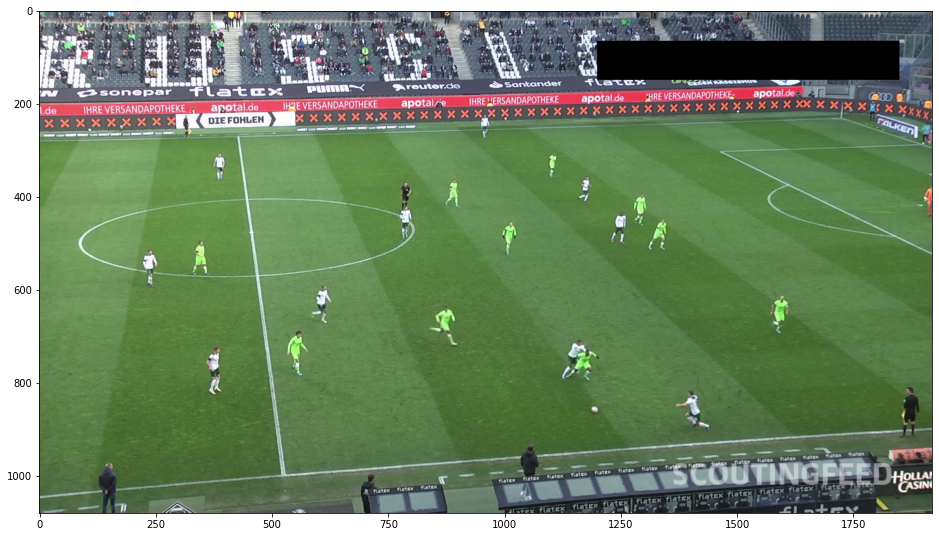

In [ ]:
frame = next(frame_iterator)
plot_image(frame, 16)

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device=0)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


ImportError: ignored

In [ ]:
results = model(frame, size=1280)

NameError: ignored

In [ ]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 1 ball, 1 goalkeeper, 19 players, 3 referees
Speed: 23.7ms pre-process, 5198.9ms inference, 75.2ms NMS per image at shape (1, 3, 768, 1280)

In [ ]:
results.pred[0]

tensor([[5.33234e+02, 6.87570e+02, 5.78573e+02, 7.84712e+02, 9.73769e-01, 2.00000e+00],
        [3.27560e+02, 4.94221e+02, 3.67715e+02, 5.70054e+02, 9.72061e-01, 2.00000e+00],
        [1.36868e+03, 8.16015e+02, 1.44455e+03, 9.04930e+02, 9.71974e-01, 2.00000e+00],
        [1.30964e+03, 4.47144e+02, 1.35070e+03, 5.16344e+02, 9.67860e-01, 2.00000e+00],
        [1.85383e+03, 8.07013e+02, 1.89357e+03, 9.18096e+02, 9.66307e-01, 3.00000e+00],
        [8.47532e+02, 6.34075e+02, 9.00840e+02, 7.21330e+02, 9.66143e-01, 2.00000e+00],
        [2.21989e+02, 5.13461e+02, 2.55608e+02, 5.94411e+02, 9.64198e-01, 2.00000e+00],
        [1.12392e+03, 7.07760e+02, 1.18086e+03, 7.92754e+02, 9.63277e-01, 2.00000e+00],
        [9.96095e+02, 4.54108e+02, 1.02639e+03, 5.26345e+02, 9.62843e-01, 2.00000e+00],
        [1.57265e+03, 6.11327e+02, 1.61230e+03, 6.94755e+02, 9.62607e-01, 2.00000e+00],
        [1.22946e+03, 4.31551e+02, 1.26351e+03, 5.01717e+02, 9.62112e-01, 2.00000e+00],
        [8.73488e+02, 3.61339e+0

In [ ]:
model.names